In [106]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [107]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [4]:
!unzip -q /content/Combinedimages.zip


In [5]:
!unzip -q /content/Combimed_mask_images.zip

In [108]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [109]:
import pandas as pd

In [110]:
num_classes = 1
input_shape = (100, 100, 3)

In [111]:
path_to_images = '/content/Combined images'

# Create an empty list to store the image data
image_data_list = []


# Loop through each file in the directory
for i in os.listdir(path_to_images):
  imagepath = path_to_images + '/' +str(i)
  images = Image.open(imagepath)
  #images.show()
  
  # Convert each image to a numpy array and append to the list
  image_data_list.append(np.array(images.resize((100, 100))))

# Convert the list of image data to a numpy array
image_data = np.array(image_data_list)

# Print the shape of the numpy array
print("Shape of image_data:", image_data.shape)


Shape of image_data: (71, 100, 100, 3)


In [112]:
import cv2
thresh = 200

path_to_labels = '/content/Combimed_mask_images'

# Create an empty list to store the label data
label_data_list = []

# Loop through each file in the directory
for l in os.listdir(path_to_labels):
  labelpath = path_to_labels + '/' +str(l)
  labels = Image.open(labelpath)
  fn = lambda x : 255 if x > thresh else 0
  labels = labels.convert('L').point(fn, mode='1')
  #labels.show()


  # Convert each label to a numpy array and append to the list
  label_data_list.append(np.array(labels.resize((1, 1))))

# Convert the list of label data to a numpy array
label_data = np.array(label_data_list)

# Print the shape of the numpy array
print("Shape of Label_data:", label_data.shape)

Shape of Label_data: (71, 1, 1)


In [113]:
label_data=label_data.astype(int)
print(len(label_data))

71


In [114]:
np.unique(label_data)

array([0, 1])

In [115]:
from imblearn.over_sampling import SMOTE


In [116]:
image_data=image_data.reshape(71,30000)

In [117]:
label_data=label_data.reshape(71,1)

In [118]:
sm = SMOTE(random_state=42)
image_data, label_data = sm.fit_resample(image_data, label_data)

In [119]:
image_data.shape

(78, 30000)

In [120]:
image_data=image_data.reshape(78,100,100,3)

In [182]:
label_data = label_data.reshape(78,1)

In [183]:
np.unique(label_data, return_counts=True)

(array([0, 1]), array([39, 39]))

In [184]:
# label_data=label_data.astype(int)
# print(len(label_data))

In [122]:
#@title Default title text
# Split the data into training and testing sets
# Assuming that you have loaded your image and label data into x and y variables respectively
x_train, x_test, y_train, y_test = train_test_split(image_data,label_data, test_size=0.2, random_state=42)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (62, 100, 100, 3) - y_train shape: (62, 1, 1)
x_test shape: (16, 100, 100, 3) - y_test shape: (16, 1, 1)
x_train shape: (62, 100, 100, 3) - y_train shape: (62, 1)
x_test shape: (16, 100, 100, 3) - y_test shape: (16, 1)


In [173]:
from sklearn.model_selection import train_test_split

In [185]:
x_train, x_test, y_train, y_test = train_test_split(image_data,label_data, test_size=0.2, random_state=42,stratify=label_data)

In [186]:
image_data.shape

(78, 100, 100, 3)

In [187]:
label_data.shape 

(78, 1)

In [188]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (62, 100, 100, 3) - y_train shape: (62, 1)
x_test shape: (16, 100, 100, 3) - y_test shape: (16, 1)


In [190]:
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72 # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [191]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [192]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [193]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
            
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


(1, 72, 72, 3)
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


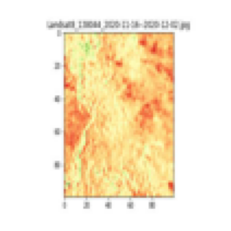

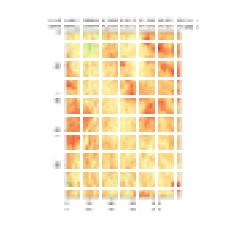

In [194]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

#print(image)

patches = Patches(patch_size)(resized_image)
print(resized_image.shape)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [195]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [196]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    print(logits)
    # Create the Keras model.
    print(inputs.shape)
    print(logits.shape)
    model = keras.Model(inputs=inputs, outputs=logits)

    return model

In [197]:
print(x_train.shape)
print(y_train.shape)

(62, 100, 100, 3)
(62, 1)


In [198]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,

        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
  
    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
    )

   
    return history


In [199]:
vit_classifier = create_vit_classifier()

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_99/BiasAdd:0', description="created by layer 'dense_99'")
(None, 100, 100, 3)
(None, 1)


In [200]:
history = run_experiment(vit_classifier)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_5[0][0]']                
                                                                                                  
 patches_8 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder_4 (PatchEncoder)  (None, 144, 64)     16192       ['patches_8[0][0]']        

1/1 [==============================] - 19s 19s/step - loss: 5.7452 - accuracy: 0.5510 - val_loss: 7.2857 - val_accuracy: 0.4615
Epoch 2/100
1/1 [==============================] - 1s 534ms/step - loss: 7.5656 - accuracy: 0.4898 - val_loss: 7.2034 - val_accuracy: 0.4615
Epoch 3/100
1/1 [==============================] - 0s 436ms/step - loss: 7.5688 - accuracy: 0.4694 - val_loss: 8.2111 - val_accuracy: 0.4615
Epoch 4/100
1/1 [==============================] - 1s 557ms/step - loss: 7.2108 - accuracy: 0.5102 - val_loss: 8.2111 - val_accuracy: 0.4615
Epoch 5/100
1/1 [==============================] - 1s 709ms/step - loss: 6.7757 - accuracy: 0.4694 - val_loss: 8.2111 - val_accuracy: 0.4615
Epoch 6/100
1/1 [==============================] - 1s 702ms/step - loss: 6.3274 - accuracy: 0.5306 - val_loss: 8.2111 - val_accuracy: 0.4615
Epoch 7/100
1/1 [==============================] - 1s 719ms/step - loss: 6.9308 - accuracy: 0.5306 - val_loss: 8.2111 - val_accuracy: 0.4615
Epoch 8/100
1/1 [=========

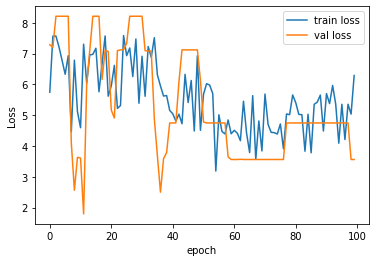

In [201]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

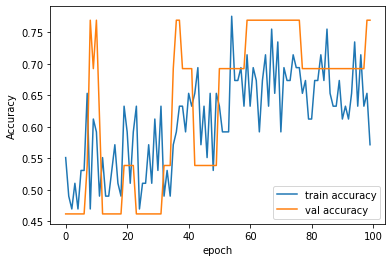

In [202]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()

In [136]:
pred_train = vit_classifier.predict(x_train, batch_size=1)


print(len(pred_train))

62/62 [==============================] - 2s 11ms/step
62


In [203]:
print(pred_train)

[[ -8.]
 [ -5.]
 [ -5.]
 [  4.]
 [-11.]
 [ -5.]
 [ -7.]
 [  1.]
 [  2.]
 [ -0.]
 [  1.]
 [ -7.]
 [  4.]
 [  4.]
 [ -7.]
 [  5.]
 [-11.]
 [ -7.]
 [-10.]
 [ -1.]
 [ -8.]
 [ -7.]
 [-10.]
 [ -7.]
 [ -7.]
 [ -8.]
 [ -8.]
 [ -9.]
 [ -5.]
 [ -6.]
 [  4.]
 [  0.]
 [ -2.]
 [-10.]
 [  5.]
 [  2.]
 [ -7.]
 [ -8.]
 [ -8.]
 [ -8.]
 [ -2.]
 [-10.]
 [ -5.]
 [ -8.]
 [ -4.]
 [ -7.]
 [  4.]
 [ -6.]
 [-10.]
 [ -6.]
 [ -9.]
 [ -6.]
 [ -6.]
 [ -2.]
 [ -4.]
 [  2.]
 [  0.]
 [ -5.]
 [ -4.]
 [  3.]
 [  5.]
 [  2.]]


In [204]:
pred_train=pred_train.round()

In [205]:
np.unique(pred_train)

array([-11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -2.,  -1.,  -0.,
         1.,   2.,   3.,   4.,   5.], dtype=float32)

In [208]:
train_pred=[]
for i in range(len(pred_train)):
  
  if pred_train[i] > 0:
    train_pred.append(1)
  else:
    train_pred.append(0)

print(train_pred)

[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]


In [209]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, classification_report

In [210]:
accuracy = accuracy_score(y_train, train_pred)
print(accuracy)

0.5161290322580645


In [211]:
pred_test = vit_classifier.predict(x_test, batch_size=1)

16/16 [==============================] - 2s 13ms/step


In [212]:
print(pred_test)

[[-6.813495 ]
 [ 4.9141364]
 [-2.7394145]
 [-2.6245594]
 [-7.2023306]
 [-4.5630937]
 [-5.537647 ]
 [ 7.265487 ]
 [13.274101 ]
 [13.769852 ]
 [13.481582 ]
 [-1.9741588]
 [-2.3832076]
 [10.124963 ]
 [-8.18595  ]
 [-2.6208062]]


In [213]:
pred_test=pred_test.round()

In [214]:
np.unique(pred_test)

array([-8., -7., -6., -5., -3., -2.,  5.,  7., 10., 13., 14.],
      dtype=float32)

In [215]:
test_pred=[]
for i in range(len(pred_test)):
  
  if pred_test[i] > 0:
    test_pred.append(1)
  else:
    test_pred.append(0)

print(test_pred)

[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


In [216]:
accuracy = accuracy_score(y_test, test_pred)
print(accuracy)

0.75


In [217]:
report = classification_report(y_test, test_pred)

In [218]:
accuracy = accuracy_score(y_test, test_pred)

precision = precision_score(y_test, test_pred, average='weighted')
f1 = f1_score(y_test, test_pred, average='weighted')
recall = recall_score(y_test, test_pred, average='weighted')
#Loss = history.history['loss'][4]
#print(history.history['loss'])
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("F1 Score", f1)
print("Recall:", recall)
report = classification_report(y_test, test_pred)
print(report)

Accuracy:  0.75
Precision:  0.7666666666666666
F1 Score 0.746031746031746
Recall: 0.75
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.83      0.62      0.71         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16



In [219]:
import seaborn as sns

[[7 1]
 [3 5]]


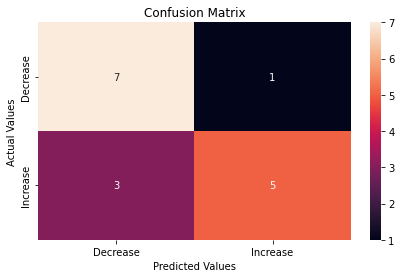

In [220]:
cm = confusion_matrix(y_test, test_pred)
print(cm)
    
    
cm_df = pd.DataFrame(cm,
                     index = ['Decrease','Increase'], 
                     columns = ['Decrease','Increase'])
    #Plotting the confusion matrix
plt.figure(figsize=(7,4))
sns.heatmap(cm_df, annot=True, fmt ='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

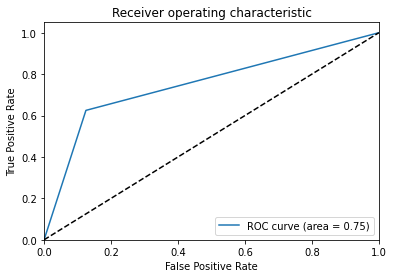

In [221]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# assuming you have already trained a binary classification model and have predicted probabilities for the test set
fpr, tpr, thresholds = roc_curve(y_test, test_pred)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()